In [5]:
path='C:/Users/sdm/Desktop/人工智能文档/开课吧培训/课程/NLP课/第七节课-20191117/assignment-07/'
# path="./"

In [6]:
from io import open
import glob
import os
import matplotlib.pyplot as plt


def find_files(path): return glob.glob(path)

print(find_files(path+'data/names/*.txt'))

['C:/Users/sdm/Desktop/人工智能文档/开课吧培训/课程/NLP课/第七节课-20191117/assignment-07/data/names\\Arabic.txt', 'C:/Users/sdm/Desktop/人工智能文档/开课吧培训/课程/NLP课/第七节课-20191117/assignment-07/data/names\\Chinese.txt', 'C:/Users/sdm/Desktop/人工智能文档/开课吧培训/课程/NLP课/第七节课-20191117/assignment-07/data/names\\Czech.txt', 'C:/Users/sdm/Desktop/人工智能文档/开课吧培训/课程/NLP课/第七节课-20191117/assignment-07/data/names\\Dutch.txt', 'C:/Users/sdm/Desktop/人工智能文档/开课吧培训/课程/NLP课/第七节课-20191117/assignment-07/data/names\\English.txt', 'C:/Users/sdm/Desktop/人工智能文档/开课吧培训/课程/NLP课/第七节课-20191117/assignment-07/data/names\\French.txt', 'C:/Users/sdm/Desktop/人工智能文档/开课吧培训/课程/NLP课/第七节课-20191117/assignment-07/data/names\\German.txt', 'C:/Users/sdm/Desktop/人工智能文档/开课吧培训/课程/NLP课/第七节课-20191117/assignment-07/data/names\\Greek.txt', 'C:/Users/sdm/Desktop/人工智能文档/开课吧培训/课程/NLP课/第七节课-20191117/assignment-07/data/names\\Irish.txt', 'C:/Users/sdm/Desktop/人工智能文档/开课吧培训/课程/NLP课/第七节课-20191117/assignment-07/data/names\\Italian.txt', 'C:/Users/sdm/Desktop/人工智能文档/开课吧培训/课程/NL

In [7]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_2_Ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_2_Ascii('Ślusàrski'))

Slusarski


In [8]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_2_Ascii(line) for line in lines]

for filename in find_files(path+'data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [9]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_index('J'))
print(letter_to_tensor('J').size())
print(line_to_tensor('Jones').size())

35
torch.Size([1, 57])
torch.Size([5, 1, 57])


In [36]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h =  nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o =  nn.Linear(input_size + hidden_size, output_size)
        
        
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [37]:
rnn = RNN(n_letters, n_hidden, n_categories)

In [10]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [14]:
import random

def sample(l):
    return l[random.randint(0, len(l) - 1)]

def sample_trainning():
    category = sample(all_categories)
    line = sample(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = sample_trainning()
    print('category =', category, '/ line =', line)

category = Polish / line = Starek
category = Italian / line = Brambilla
category = Polish / line = Szwarc
category = Arabic / line = Assaf
category = Japanese / line = Fujimaki
category = Spanish / line = Gonzalez
category = Arabic / line = Srour
category = Russian / line = Abdulgaziev
category = Greek / line = Vamvakidis
category = Irish / line = Bradach


In [34]:
criterion = nn.CrossEntropyLoss()

In [38]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [39]:
import time
import math

n_iters = 100000 # 这个数字你可以调大一些
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 9s) 2.2318 Bagomaev / Russian ✓
10000 10% (0m 20s) 1.5887 Dieter / German ✓
15000 15% (0m 31s) 1.5823 Luong / Chinese ✗ (Vietnamese)
20000 20% (0m 41s) 2.3231 Fonseca / Spanish ✗ (Portuguese)
25000 25% (0m 52s) 1.1925 Ziemniak / Polish ✓
30000 30% (1m 2s) 1.1029 So / Korean ✓
35000 35% (1m 12s) 1.4483 Hafernik / Czech ✓
40000 40% (1m 25s) 1.2972 Magro / Italian ✓
45000 45% (1m 36s) 4.3363 William / Czech ✗ (Irish)
50000 50% (1m 48s) 2.9277 Kouman / Vietnamese ✗ (Dutch)
55000 55% (1m 58s) 1.8698 Hughes / Dutch ✗ (Scottish)
60000 60% (2m 8s) 0.5164 Kakinomoto / Japanese ✓
65000 65% (2m 17s) 1.0424 Long / Vietnamese ✗ (Chinese)
70000 70% (2m 28s) 0.0782 Quang / Vietnamese ✓
75000 75% (2m 39s) 0.6961 Domhnall / Irish ✓
80000 80% (2m 50s) 4.4200 Tait / Arabic ✗ (English)
85000 85% (3m 0s) 1.1585 Apsley / English ✓
90000 90% (3m 10s) 1.7235 Ferguson / French ✗ (Scottish)
95000 95% (3m 19s) 0.2632 Minatoya / Japanese ✓
100000 100% (3m 29s) 2.5365 Robertson / Dutch ✗ (Scottish)


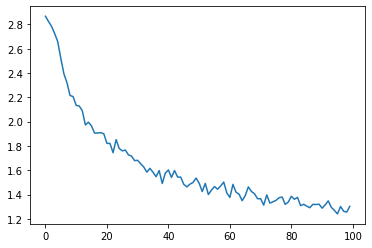

In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [41]:
all_losses

[2.8671992185115815,
 2.8242604134082794,
 2.783838767528534,
 2.7253047099113465,
 2.658275889992714,
 2.5221645455360413,
 2.3946090266108513,
 2.3211671797037123,
 2.2154441780000926,
 2.206122488602996,
 2.1335751409567894,
 2.1284950201287867,
 2.0891503945365546,
 1.9723900456503034,
 1.9953574823942035,
 1.964101244814694,
 1.905790587052703,
 1.9064878779910506,
 1.9091576453782617,
 1.9000025466047228,
 1.8211288860924542,
 1.8205091057568787,
 1.7443018947523088,
 1.8521036383584142,
 1.7792717952369712,
 1.7592088819756173,
 1.7660950023122133,
 1.7266267627738416,
 1.7162997601879761,
 1.67921721528098,
 1.6815792341092601,
 1.6532532358234748,
 1.6261299344813451,
 1.5841328002773225,
 1.6157599345371128,
 1.583125220440328,
 1.5468776931669563,
 1.597319180497434,
 1.4908824297243264,
 1.5765201669652016,
 1.6025449600247665,
 1.54057756018918,
 1.5975311008226127,
 1.5435982555197552,
 1.5436725433999672,
 1.4841113036470488,
 1.4629207886289806,
 1.4852199198598974,
 1.

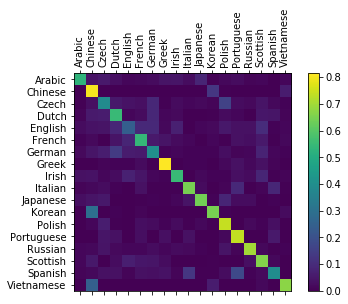

In [42]:
# 在混淆矩阵中跟踪正确的猜测
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 只需返回给定一行的输出
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# 查看一堆正确猜到的例子和记录
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = sample_trainning()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 通过将每一行除以其总和来归一化
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 设置绘图
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 设置轴
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 每个刻度线强制标签
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [14]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-1.39) Polish
(-1.84) Russian
(-2.66) English

> Jackson
(-1.81) Russian
(-1.93) Scottish
(-2.29) Irish

> Satoshi
(-1.64) Polish
(-2.07) Italian
(-2.13) Japanese


## 代码练习

### 1. 尝试在我们的RNN模型中添加更多layers，然后观察Loss变化

ANS:添加2层Linear后，没有明显差别，Loss收敛性变慢，模型效果略微变差。

In [43]:
import torch.nn as nn

class RNN_3layers(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_3layers, self).__init__()

        self.hidden_size = hidden_size

        self.i2h =  nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o =  nn.Linear(input_size + hidden_size, output_size)
        
        self.i2h2 = nn.Linear(hidden_size, hidden_size)
        self.i2o2 = nn.Linear(output_size, output_size)
        
        self.i2h3 = nn.Linear(hidden_size, hidden_size)
        self.i2o3 = nn.Linear(output_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        
        hidden = self.i2h2(nn.ReLU()(hidden))
        output = self.i2o2(nn.ReLU()(output))
        
        hidden = self.i2h3(nn.ReLU()(hidden))
        output = self.i2o3(nn.ReLU()(output))
        
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [44]:
rnn = RNN_3layers(n_letters, n_hidden, n_categories)

In [45]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [46]:
import time
import math

n_iters = 100000 # 这个数字你可以调大一些
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 30s) 2.9040 Tunison / Chinese ✗ (Dutch)
10000 10% (0m 58s) 2.8517 Park  / German ✗ (Korean)
15000 15% (1m 31s) 2.5593 Vela / Italian ✗ (Spanish)
20000 20% (2m 0s) 2.7287 Campbell / German ✗ (Scottish)
25000 25% (2m 27s) 2.8599 Masih / Scottish ✗ (Arabic)
30000 30% (2m 56s) 0.7203 Alesini / Italian ✓
35000 35% (3m 28s) 1.5467 Ibanez / Spanish ✓
40000 40% (4m 0s) 1.9582 Mcdonald / English ✗ (Scottish)
45000 45% (4m 30s) 3.5142 Mozdzierz / Spanish ✗ (Polish)
50000 50% (5m 2s) 1.3942 Dubhain / Russian ✗ (Irish)
55000 55% (5m 31s) 0.9557 Gallego / Spanish ✓
60000 60% (6m 0s) 2.0219 Maille / French ✗ (Irish)
65000 65% (6m 29s) 1.6293 Castellano / Italian ✗ (Spanish)
70000 70% (6m 59s) 2.0681 Richard / Irish ✗ (French)
75000 75% (7m 26s) 0.4884 Hernandez / Spanish ✓
80000 80% (7m 55s) 0.8969 Romao / Portuguese ✓
85000 85% (8m 26s) 3.5376 King / Chinese ✗ (Scottish)
90000 90% (8m 54s) 1.0800 Davidson / Scottish ✓
95000 95% (9m 27s) 1.8846 Khu / Vietnamese ✗ (Chinese)
100000 100% (9

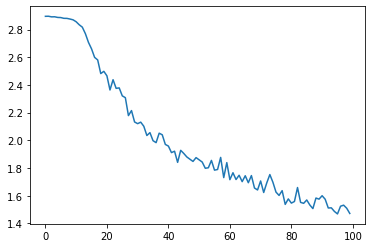

In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [48]:
all_losses

[2.895441816329956,
 2.89598729467392,
 2.8915471856594084,
 2.8921479291915895,
 2.887409501075745,
 2.8864642264842986,
 2.8809861443042757,
 2.8805340094566345,
 2.875867814064026,
 2.8700971488952636,
 2.856144301176071,
 2.834353263139725,
 2.817250936746597,
 2.7701506757736207,
 2.707360284090042,
 2.660621298670769,
 2.5990035127401354,
 2.580526712059975,
 2.481898810625076,
 2.49813924151659,
 2.4658696221113203,
 2.363508204460144,
 2.43767214846611,
 2.375338232278824,
 2.37847513961792,
 2.3210751233100892,
 2.307951866090298,
 2.1785091069340705,
 2.2147106686234475,
 2.1325115874409675,
 2.1202939984202387,
 2.131116500914097,
 2.101433586701751,
 2.034716876938939,
 2.0554535016715527,
 1.997361770197749,
 1.9832149652838706,
 2.0514981147646902,
 2.0399130650162696,
 1.9703325528800488,
 1.9583964484930039,
 1.9111503112837673,
 1.9212577019333839,
 1.8407221232131123,
 1.9277868635728956,
 1.9051450575441122,
 1.8798170286417006,
 1.8634970781430602,
 1.84748877976089

### 2. 将原始的RNN模型改成nn.LSTM和nn.GRU， 并且改变 `n_iters = 1000 ` 这个值，观察其变化

nn.LSTM:LSTM模型效果较差；
nn.GRU:GRU模型效果较差；

In [55]:
import torch.nn as nn

class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,num_layer=2):
        super(RNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layer = num_layer

        self.LSTM = nn.LSTM(input_size, hidden_size, num_layer)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input):
        hidden = self.initHidden()
        output, hidden = self.LSTM(input, hidden)
        output = self.linear(output[-1])
        output = self.softmax(output)
        return output
    
    def initHidden(self):
        return (torch.zeros(self.num_layer, 1, self.hidden_size),
                torch.zeros(self.num_layer, 1, self.hidden_size))

n_hidden = 128

In [56]:
rnn = RNN_LSTM(n_letters, n_hidden, n_categories,2)

In [57]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    rnn.zero_grad()

    output = rnn(line_tensor)
#     print("output:",output.shape)
#     print("category_tensor:",category_tensor.shape)
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [58]:
import time
import math

n_iters = 50000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 1% (0m 3s) 2.8812 Brambani / Korean ✗ (Italian)
1000 2% (0m 6s) 2.9040 Ruan / English ✗ (Chinese)
1500 3% (0m 10s) 2.8983 Leroy / Korean ✗ (French)
2000 4% (0m 14s) 2.8354 Matsyuk / Portuguese ✗ (Russian)
2500 5% (0m 17s) 2.8615 Giannakopoulos / Portuguese ✗ (Greek)
3000 6% (0m 21s) 2.9271 Bleskan / Portuguese ✗ (Czech)
3500 7% (0m 26s) 2.8672 Dasios / Portuguese ✗ (Greek)
4000 8% (0m 30s) 2.9075 Yamanoue / Russian ✗ (Japanese)
4500 9% (0m 34s) 2.9002 Schorel / Russian ✗ (Dutch)
5000 10% (0m 38s) 2.8461 Blahut / Russian ✗ (Czech)
5500 11% (0m 42s) 2.8151 Piontek / Russian ✗ (Polish)
6000 12% (0m 46s) 2.8100 Chu / Korean ✓
6500 13% (0m 49s) 2.9488 Daalen / Portuguese ✗ (Dutch)
7000 14% (0m 53s) 2.8758 Tritten / Irish ✗ (German)
7500 15% (0m 57s) 2.9300 Seeger / Portuguese ✗ (Dutch)
8000 16% (1m 1s) 2.9812 Ortiz / Portuguese ✗ (Spanish)
8500 17% (1m 4s) 2.8219 Haanraads / Greek ✗ (Dutch)
9000 18% (1m 8s) 2.8802 Mcintosh / Greek ✗ (Scottish)
9500 19% (1m 12s) 2.8089 Arvanitoyannis / I

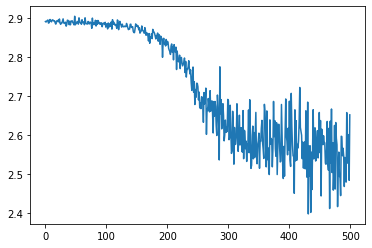

In [59]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [60]:
all_losses

[2.8918790006637574,
 2.890500965118408,
 2.8927930760383607,
 2.8944684362411497,
 2.895729479789734,
 2.887801315784454,
 2.888503017425537,
 2.8967403292655947,
 2.8968403697013856,
 2.8922134804725648,
 2.8910284209251405,
 2.8953662395477293,
 2.8962622928619384,
 2.8944201111793517,
 2.893074929714203,
 2.89378977060318,
 2.888377809524536,
 2.8851987862586976,
 2.891776216030121,
 2.8940788960456847,
 2.8916611170768736,
 2.8953897643089292,
 2.8909654021263123,
 2.898328256607056,
 2.8874525451660156,
 2.884636309146881,
 2.8877723956108095,
 2.8878639698028565,
 2.8935320472717283,
 2.8986740255355836,
 2.8886367678642273,
 2.8867047142982485,
 2.888033812046051,
 2.8901077628135683,
 2.879904727935791,
 2.883968288898468,
 2.8952700686454773,
 2.8948578071594238,
 2.89202308177948,
 2.8836385655403136,
 2.8927782368659973,
 2.8834231758117674,
 2.892788863182068,
 2.892023923397064,
 2.8937330174446108,
 2.888899462223053,
 2.887136471271515,
 2.8832335567474363,
 2.905416991

GRU

In [85]:
import torch.nn as nn

class RNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,num_layer=2):
        super(RNN_GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layer = num_layer
        
        self.GRU = nn.GRU(input_size, hidden_size,num_layer)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        hidden = self.initHidden()
        output, hidden = self.GRU(input, hidden)
        output = self.linear(output[-1])
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(self.num_layer, 1, self.hidden_size))

n_hidden = 128

In [73]:
criterion = nn.CrossEntropyLoss()

In [86]:
rnn = RNN_GRU(n_letters, n_hidden, n_categories,2)

In [75]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    rnn.zero_grad()

    output, hidden = rnn(line_tensor)
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [87]:
import time
import math

n_iters = 50000 
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 1% (0m 3s) 2.7841 Mondadori / Czech ✗ (Italian)
1000 2% (0m 7s) 2.9127 Kappel / Czech ✗ (German)
1500 3% (0m 11s) 2.9141 Kolen / Polish ✗ (Dutch)
2000 4% (0m 15s) 2.9106 Moreno / Italian ✗ (Portuguese)
2500 5% (0m 19s) 2.9563 Asker / Czech ✗ (Arabic)
3000 6% (0m 23s) 2.8416 Walters / Dutch ✗ (English)
3500 7% (0m 27s) 2.9001 Fabian / Dutch ✗ (Polish)
4000 8% (0m 31s) 2.8520 Viola / Dutch ✗ (Italian)
4500 9% (0m 35s) 2.8241 Lauritz / Russian ✗ (German)
5000 10% (0m 39s) 2.7889 Paterson / Russian ✗ (Scottish)
5500 11% (0m 43s) 2.9288 Hadjiyianakies / Russian ✗ (Greek)
6000 12% (0m 47s) 2.8851 Donchak / Czech ✗ (Russian)
6500 13% (0m 52s) 2.7027 Gunther / German ✓
7000 14% (0m 56s) 2.7541 Lychakov / German ✗ (Russian)
7500 15% (1m 0s) 2.8416 Mcintyre / Russian ✗ (Scottish)
8000 16% (1m 3s) 2.7328 Meeuwe / French ✗ (Dutch)
8500 17% (1m 7s) 2.9261 Abbing / Scottish ✗ (German)
9000 18% (1m 10s) 2.9829 Qureshi / Russian ✗ (Arabic)
9500 19% (1m 14s) 2.8799 Rheem / French ✗ (Korean)
10000 2

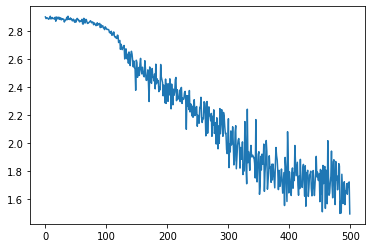

In [89]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [90]:
all_losses

[2.898250856399536,
 2.886566791534424,
 2.8900496196746825,
 2.8916883444786072,
 2.889924805164337,
 2.882010028362274,
 2.884500126838684,
 2.890397856235504,
 2.903165080547333,
 2.883373427391052,
 2.8876038789749146,
 2.894759361743927,
 2.8863113784790038,
 2.8883692979812623,
 2.8857048320770264,
 2.8838765835762024,
 2.896115758419037,
 2.867733209133148,
 2.8971117305755616,
 2.896651840209961,
 2.8846992373466493,
 2.886242651939392,
 2.8967137503623963,
 2.881166260242462,
 2.890444414615631,
 2.8920621562004087,
 2.8774586629867556,
 2.886387758255005,
 2.8808717632293703,
 2.8832941460609436,
 2.8822335410118103,
 2.8621225333213807,
 2.8741153979301455,
 2.873188338279724,
 2.8801996874809266,
 2.895251462459564,
 2.878960864543915,
 2.9032672905921935,
 2.8810631275177,
 2.884696319103241,
 2.8796213030815125,
 2.89117222070694,
 2.8793865299224852,
 2.883788924217224,
 2.871243643760681,
 2.8708513045310973,
 2.8822237133979796,
 2.870738596916199,
 2.860433418750763,


### 3. 把该RNN模型变成多层RNN模型，观察Loss的变化

ANS:多层RNN模型，模型效果没有明显提升，Loss收敛性好一些。
    

In [151]:
import torch.nn as nn

class deep_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(deep_RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h =  nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o =  nn.Linear(input_size + hidden_size, input_size)
        
        self.i2h2 = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o2 = nn.Linear(input_size + hidden_size, input_size)
        
        self.i2h3 = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o3 = nn.Linear(input_size + hidden_size, input_size)
        
        self.i4o4 = nn.Linear(input_size, output_size)
            
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden1,hidden2,hidden3):
        combined = torch.cat((input, hidden1), 1)
        hidden1 = self.i2h(combined)
        output = self.i2o(combined) 
        
        combined = torch.cat((output, hidden2), 1)
        hidden2 = self.i2h2(nn.ReLU()(combined))
        output = self.i2o2(nn.ReLU()(combined))
        
        combined = torch.cat((output, hidden3), 1)
        hidden3 = self.i2h3(nn.ReLU()(combined))
        output = self.i2o3(nn.ReLU()(combined))

        output = self.i4o4(nn.ReLU()(output))
        output = self.softmax(output)

        return output, hidden1,hidden2,hidden3

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [152]:
rnn = deep_RNN(n_letters, n_hidden, n_categories)

In [138]:
criterion = nn.NLLLoss()

In [153]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden1 = rnn.initHidden()
    hidden2 = rnn.initHidden()
    hidden3 = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden1,hidden2,hidden3 = rnn(line_tensor[i], hidden1,hidden2,hidden3)
        
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [155]:
import time
import math

n_iters = 100000 # 这个数字你可以调大一些
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 42s) 2.8582 Simon / Spanish ✗ (French)
10000 10% (1m 19s) 2.8769 Morrison / Vietnamese ✗ (Scottish)
15000 15% (1m 58s) 2.8736 Kessel / Vietnamese ✗ (Czech)
20000 20% (2m 36s) 1.8749 Bakihanov / Russian ✓
25000 25% (3m 12s) 2.8944 Rocco / Arabic ✗ (Italian)
30000 30% (3m 47s) 2.6867 Davidson / Polish ✗ (Scottish)
35000 35% (4m 27s) 2.3975 Sugimura / Italian ✗ (Japanese)
40000 40% (5m 13s) 1.8019 Salcedo / Japanese ✗ (Spanish)
45000 45% (5m 54s) 1.5400 Rocha / Portuguese ✓
50000 50% (6m 32s) 1.8600 Corlett / Dutch ✗ (English)
55000 55% (7m 10s) 1.8100 Canne / German ✗ (Dutch)
60000 60% (7m 52s) 2.4199 Rossem / Czech ✗ (Dutch)
65000 65% (8m 58s) 5.3962 Swango / Italian ✗ (German)
70000 70% (10m 2s) 0.7598 Sortras / Greek ✓
75000 75% (11m 1s) 3.6857 Young / Vietnamese ✗ (Scottish)
80000 80% (12m 8s) 2.8059 Kosko / Polish ✗ (Czech)
85000 85% (13m 13s) 1.1850 Busto / Italian ✗ (Spanish)
90000 90% (14m 8s) 1.4231 Aller / German ✗ (Dutch)
95000 95% (15m 1s) 1.7512 Wood / Korean ✗ (

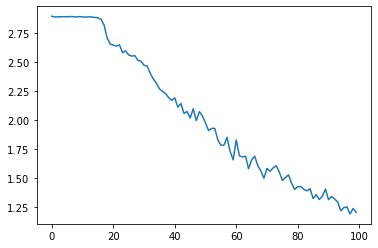

In [156]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [157]:
all_losses

[2.8951038484573366,
 2.8892548978328705,
 2.889729874134064,
 2.891170322418213,
 2.891628531932831,
 2.890265884399414,
 2.892327795267105,
 2.8916961185932157,
 2.8885889060497285,
 2.892095156431198,
 2.889648792743683,
 2.8872952139377595,
 2.8901130948066713,
 2.8877688829898833,
 2.8852657008171083,
 2.881920234441757,
 2.868704388141632,
 2.820305447459221,
 2.70822517478466,
 2.6568456134796143,
 2.6462690648138523,
 2.63788131916523,
 2.6492163408249616,
 2.582364077702165,
 2.597724746346474,
 2.562389164626598,
 2.5519780149161817,
 2.5564894085377454,
 2.5156516854166986,
 2.509165154695511,
 2.473072755932808,
 2.4668709249198435,
 2.4065791128873824,
 2.3555470538660885,
 2.319953183889389,
 2.2708895652890204,
 2.2496087460815906,
 2.230184227600694,
 2.1951750758960844,
 2.1716554904282095,
 2.1934475466012953,
 2.1138599263876676,
 2.144516838248819,
 2.059055025074631,
 2.076312521032989,
 2.019306382890791,
 2.0990823753979058,
 1.9967864847159944,
 2.07444034241139

### 4. Pytorch里边常用nn.NLLoss来代替crossentropy，将criterion改为nn.NLLoss，观察变化

ANS:添加2层Linear后，没有明显差别，模型效果略微提升。

In [49]:
rnn = RNN(n_letters, n_hidden, n_categories)

In [50]:
criterion = nn.NLLLoss()

In [51]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [52]:
import time
import math

n_iters = 100000 # 这个数字你可以调大一些
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 11s) 2.9888 Rompa / Japanese ✗ (Dutch)
10000 10% (0m 22s) 2.7918 Tsai  / Arabic ✗ (Korean)
15000 15% (0m 33s) 1.1109 Agnelli / Italian ✓
20000 20% (0m 43s) 0.8520 Ribeiro / Portuguese ✓
25000 25% (0m 54s) 1.5630 Trang / Vietnamese ✓
30000 30% (1m 5s) 2.8403 Tobiash / Japanese ✗ (Russian)
35000 35% (1m 15s) 1.7181 Smith / Scottish ✓
40000 40% (1m 26s) 0.7079 Suh / Korean ✓
45000 45% (1m 36s) 0.1515 Tsahalis / Greek ✓
50000 50% (1m 47s) 0.8022 Dziedzic / Polish ✓
55000 55% (1m 58s) 1.5223 Juzgin / Russian ✓
60000 60% (2m 9s) 1.2813 Tomanek / Polish ✗ (Czech)
65000 65% (2m 19s) 0.2161 Wojewodzki / Polish ✓
70000 70% (2m 32s) 0.6105 Cearbhall / Irish ✓
75000 75% (2m 45s) 0.0899 Jedlicka / Czech ✓
80000 80% (2m 56s) 0.1593 Slootmaekers / Dutch ✓
85000 85% (3m 8s) 0.2467 Yap / Chinese ✓
90000 90% (3m 20s) 3.7174 Plamondon / Irish ✗ (French)
95000 95% (3m 31s) 0.2821 Asghar / Arabic ✓
100000 100% (3m 42s) 0.0682 Ueshima / Japanese ✓


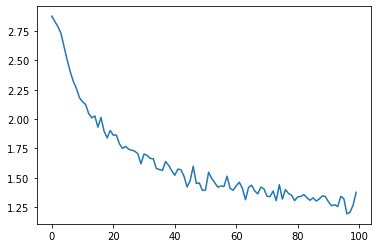

In [53]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [54]:
all_losses

[2.8762911150455475,
 2.832008758544922,
 2.787692994117737,
 2.7295270013809203,
 2.6154948301911354,
 2.50524567759037,
 2.4040796743929387,
 2.3217504228651524,
 2.2618728068768976,
 2.183000622853637,
 2.1477376331984996,
 2.1246305533498524,
 2.0476057898327706,
 2.0114079890958965,
 2.0268062107115985,
 1.9316266007572414,
 2.014738577466458,
 1.8985098862946033,
 1.8402127334699034,
 1.902698788333684,
 1.8633221035264433,
 1.8641509079560636,
 1.7897895001359283,
 1.7506797014847397,
 1.7681503957863898,
 1.7442270973846317,
 1.7349036091659218,
 1.72724236247316,
 1.7043787400349975,
 1.6195100927744062,
 1.703083276670426,
 1.6916313385348767,
 1.6656261196229607,
 1.6627840096987785,
 1.5799207647591829,
 1.570725495889783,
 1.5629823278356343,
 1.6397027544856537,
 1.6066508658844978,
 1.5617377399913968,
 1.5216826506243086,
 1.5741311855667737,
 1.569297883012332,
 1.5140870149126275,
 1.4229604953629895,
 1.4761759404554031,
 1.5983061935785225,
 1.4521078776987268,
 1.4